In [45]:
import numpy as np
import csv
import matplotlib.pyplot as plt
%matplotlib inline

import pattrex.plotting_mpl as plt_rex

# PCA

Referred to np-sp-recipes-12 (for eigenvalues/eigenvecotrs of covariance matrices)

## Import and Preprocess data

- Import data into a `numpy` array
- **normalize** the data to zero-mean

In [6]:
data_X_fp = "./data/data-dimred-X.csv"
data_y_fp = "./data/data-dimred-y.csv"

data_X = np.genfromtxt(data_X_fp, delimiter=',')
data_y = np.genfromtxt(data_y_fp, delimiter=',')

print("data : {} \nlabels : {}".format(data_X.shape, data_y.shape))

data : (500, 150) 
labels : (150,)


In [60]:
data_y

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  3.,  3.,  3.,  3.,
        3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
        3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
        3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
        3.,  3.,  3.,  3.,  3.,  3.,  3.])

In [9]:
data_X_mean = data_X.mean()
data_X_norm = data_X - data_X_mean

data_X_norm.mean()

1.8947806286936004e-17

## Caculate the Covariance Matrix

In [10]:
C_X = np.cov(data_X_norm)
C_X.shape

(500, 500)

## Do Eigen Analysis

Using `numpy.linalg.eigh(...)`

(500,)
(500, 500)


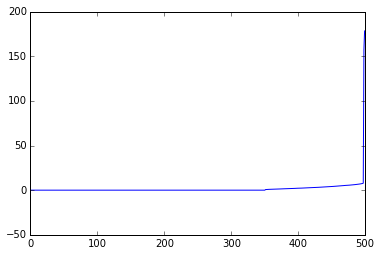

In [12]:
evals, evects = np.linalg.eigh(C_X)

print(evals.shape)
print(evects.shape)

plt.plot(np.arange(evals.size), evals)

### So, they are ascending
Let's look at the top 10

In [13]:
# sort descending
idx = np.argsort(evals)[::-1]
sorted_evals = evals[idx]
sorted_evects = evects[:, idx]

In [20]:
sorted_evals[:10]

array([ 178.36082561,  157.5026053 ,    7.76115581,    7.51579683,
          7.28021248,    7.18770618,    7.05327894,    6.87866945,
          6.8158655 ,    6.73649919])

### Let's try to find where do they sum up to 90, 95, and 99 % of the total

In [27]:
sum_s_evals = np.cumsum(sorted_evals)

def where_sum_to(X, x, side='left'):
    return np.searchsorted(X, x, side=side)

print("90%  :", where_sum_to(sum_s_evals, sum_s_evals[-1] * 0.9))
print("95%  :", where_sum_to(sum_s_evals, sum_s_evals[-1] * 0.95))
print("99%  :", where_sum_to(sum_s_evals, sum_s_evals[-1] * 0.99))
print("100% :", where_sum_to(sum_s_evals, sum_s_evals[-1] * 1.0), " First")
print("100% :", where_sum_to(sum_s_evals, sum_s_evals[-1] * 1.0, side='right'), " Last")

90%  : 94
95%  : 114
99%  : 139
100% : 148  First
100% : 500  Last


## Who Needs all of them???
Let's see how much the first two eigvals contribute

In [32]:
contrib = lambda i : 100 * sum_s_evals[i-1] / sum_s_evals[-1]

print("\n".join("First {} : {:.4} %".format(*p) for p in [(i, contrib(i)) for i in [1, 2, 3, 4, 5]]))

First 1 : 21.61 %
First 2 : 40.69 %
First 3 : 41.63 %
First 4 : 42.54 %
First 5 : 43.42 %


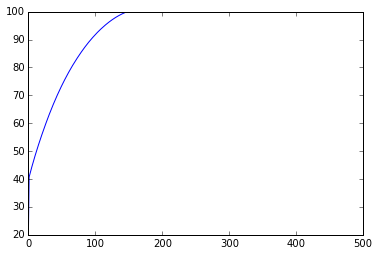

In [35]:
plt.plot([contrib(i + 1) for i in range(sum_s_evals.size)])

## Back to the task

- Choose the eigvecs corresponding to the first two (highest) eigvals
- Project the **normalized** data into $\mathbb{R}^2$
- Plot

In [37]:
eigval_2 = sorted_evals[:2]
eigvec_2 = sorted_evects[:, :2]

print(eigval_2)
# print(eigvec_2)

[ 178.36082561  157.5026053 ]


In [42]:
projection = np.dot(data_X_norm.T, eigvec_2)

projection.shape

(150, 2)

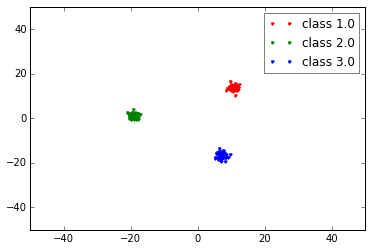

In [70]:
fig = plt.figure()
axs = fig.add_subplot(111)

for l, c in zip([1., 2., 3.], ['r.', 'g.', 'b.']):
    plt_rex.plot2d(projection[np.where(data_y == l)], False, axs=axs,
                  x_lim=[-50, 50], y_lim=[-50, 50], hatch=c, show=False,
                  plotlabel="class " + str(l))

### WooHoo